In [1]:
import sys
print(sys.executable)

C:\Users\vgaur\anaconda3\envs\env\python.exe


In [2]:
from sklearn.metrics import f1_score
#ignore the error due to this command as it's a compatibility error without any issues 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [4]:
print(torch.cuda.is_available()) 


False


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:

num_epochs=100
batch_size=4
learning_rate=0.001


In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),  # New: Added Random Rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
train_dataset=torchvision.datasets.CIFAR10(root='./data',train=True,
                                       transform = transform, download=True)
test_dataset=torchvision.datasets.CIFAR10(root='./data',train=False,
                                       transform = transform,download=True)

train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)  
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2) 
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # New: Extra Conv Layer
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)  # New: Dropout for Regularization

        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # New: Extra Conv Layer
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [11]:
model = ConvNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [12]:
criterion=nn.CrossEntropyLoss()


In [13]:
loss_values = []
f1_values = []

In [14]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        # Compute F1 Score
        _, predictions = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), predictions.cpu(), average='macro')
        f1_values.append(f1)

        running_loss += loss.item()

        if (i + 1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 2000:.4f}')
            running_loss = 0.0

    scheduler.step(running_loss)  # Reduce LR if needed

print('Finished Training')

# Save Model
torch.save(model.state_dict(), './cnn.pth')

Epoch [1/100], Step [2000/12500], Loss: 2.0953
Epoch [1/100], Step [4000/12500], Loss: 1.9410
Epoch [1/100], Step [6000/12500], Loss: 1.8251
Epoch [1/100], Step [8000/12500], Loss: 1.7710
Epoch [1/100], Step [10000/12500], Loss: 1.7010
Epoch [1/100], Step [12000/12500], Loss: 1.6555
Epoch [2/100], Step [2000/12500], Loss: 1.6245
Epoch [2/100], Step [4000/12500], Loss: 1.6121
Epoch [2/100], Step [6000/12500], Loss: 1.5885
Epoch [2/100], Step [8000/12500], Loss: 1.5533
Epoch [2/100], Step [10000/12500], Loss: 1.5210
Epoch [2/100], Step [12000/12500], Loss: 1.5101
Epoch [3/100], Step [2000/12500], Loss: 1.4733
Epoch [3/100], Step [4000/12500], Loss: 1.4717
Epoch [3/100], Step [6000/12500], Loss: 1.4566
Epoch [3/100], Step [8000/12500], Loss: 1.4494
Epoch [3/100], Step [10000/12500], Loss: 1.4283
Epoch [3/100], Step [12000/12500], Loss: 1.4148
Epoch [4/100], Step [2000/12500], Loss: 1.3856
Epoch [4/100], Step [4000/12500], Loss: 1.3980
Epoch [4/100], Step [6000/12500], Loss: 1.3742
Epoch [

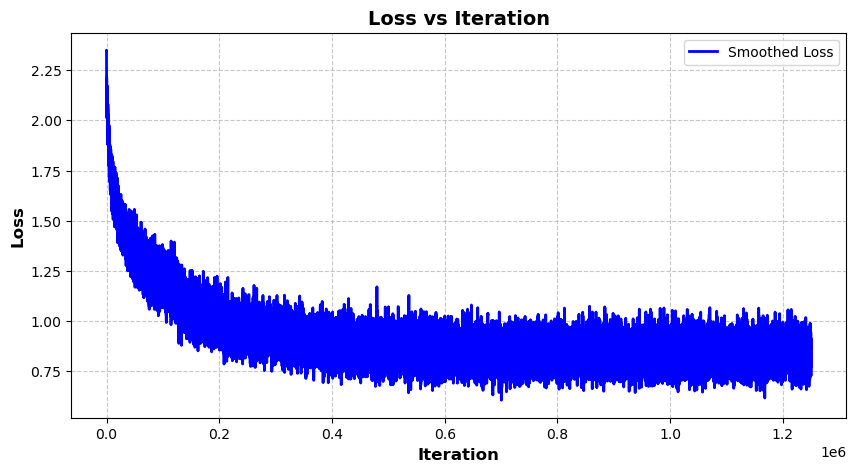

In [15]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot Loss vs Iteration with Smoothing
plt.figure(figsize=(10, 5))
plt.plot(moving_average(loss_values, 100), label='Smoothed Loss', color='blue', linewidth=2)
plt.xlabel('Iteration', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Loss vs Iteration', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [16]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(10)]
    n_class_samples = [0 for _ in range(10)]
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        n_samples += labels.size(0)
        n_correct += (predictions == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i]
            pred = predictions[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Overall Accuracy = {acc:.2f}%')

    for i in range(10):
        class_acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {class_acc:.2f}%')

Overall Accuracy = 70.01%
Accuracy of plane: 74.10%
Accuracy of car: 84.50%
Accuracy of bird: 56.40%
Accuracy of cat: 50.60%
Accuracy of deer: 66.80%
Accuracy of dog: 58.00%
Accuracy of frog: 76.90%
Accuracy of horse: 74.00%
Accuracy of ship: 81.30%
Accuracy of truck: 77.50%
